In [0]:
from __future__ import print_function
import numpy as np

import keras
from keras.datasets import cifar10
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Model
import os

from sklearn.model_selection import train_test_split

RESNET20

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

 

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model




Data Preparation

In [0]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train, X_test, y_train, Y_test = train_test_split(x_train, y_train, stratify=y_train, test_size=0.8)

N = 10

y_train = keras.utils.to_categorical(y_train, N)
y_test = keras.utils.to_categorical(y_test, N)

Training Parameters

In [0]:

batch_size = 128 
epochs = 100
#N = 10

n=3
depth = n*6+2
model_type = 'ResNet%dv' % (depth)


Model

In [17]:

model = resnet_v2(input_shape=input_shape, depth=depth)


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

plot = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

#Final Scores
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 13s 1ms/step - loss: 2.1902 - accuracy: 0.3537 - val_loss: 3.2061 - val_accuracy: 0.1876
Epoch 2/100
10000/10000 [==============================] - 10s 954us/step - loss: 1.8319 - accuracy: 0.4817 - val_loss: 4.2224 - val_accuracy: 0.1594
Epoch 3/100
10000/10000 [==============================] - 10s 957us/step - loss: 1.6473 - accuracy: 0.5432 - val_loss: 3.5320 - val_accuracy: 0.1991
Epoch 4/100
10000/10000 [==============================] - 10s 953us/step - loss: 1.4745 - accuracy: 0.6046 - val_loss: 2.8529 - val_accuracy: 0.3113
Epoch 5/100
10000/10000 [==============================] - 10s 966us/step - loss: 1.3013 - accuracy: 0.6669 - val_loss: 2.3195 - val_accuracy: 0.4001
Epoch 6/100
10000/10000 [==============================] - 10s 957us/step - loss: 1.1691 - accuracy: 0.7176 - val_loss: 2.4743 - val_accuracy: 0.3649
Epoch 7/100
10000/10000 [===========================

Plot : Accuracy

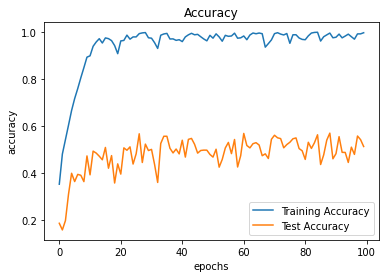

In [18]:

import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(plot.history['accuracy'], label='Training Accuracy')
plt.plot(plot.history['val_accuracy'], label='Test Accuracy')
#plt.plot(plot.history['loss'], label='Training Loss')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

Plot : Loss 

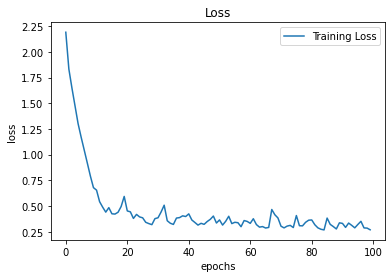

In [19]:
plt.plot(plot.history['loss'], label='Training Loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()